*Retail Store Inventory Forecasting dataset for
analysis*

**Dataset Link:** https://www.kaggle.com/datasets/anirudhchauhan/retail-store-inventory-forecasting-dataset

In [2]:
!git clone https://github.com/aabdullahsayed/Retail-inventory-forecasting-using-machine-learning-and-data-driven-business-insights.git

Cloning into 'Retail-inventory-forecasting-using-machine-learning-and-data-driven-business-insights'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), 1.50 MiB | 14.05 MiB/s, done.


# Data Preparation

In [52]:
import pandas as pd
import numpy as np



In [64]:

# Load the dataset
df = pd.read_csv('/content/Retail-inventory-forecasting-using-machine-learning-and-data-driven-business-insights/retail_store_inventory.csv')

# Verify dimensions and preview data
print("First 5 rows of data:")
display(df.head())

First 5 rows of data:


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [61]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)
    print("✅ Date column converted and data sorted.")
else:
    print("❌ Error: 'Date' column missing.")


✅ Date column converted and data sorted.


In [62]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

display(df[['Date', 'Year', 'Month', 'Week']].head())


,Date,Year,Month,Week
0,2022-01-01,2022,1,52
72,2022-01-01,2022,1,52
71,2022-01-01,2022,1,52
70,2022-01-01,2022,1,52
69,2022-01-01,2022,1,52


In [66]:
print("\n Missing values before cleaning:")
display(df.isnull().sum())



 Missing values before cleaning:


,0
Date,0
Store ID,0
Product ID,0
Category,0
Region,0
Inventory Level,0
Units Sold,0
Units Ordered,0
Demand Forecast,0
Price,0


In [67]:
# Remove invalid negative sales
df = df[df['Units Sold'] >= 0]

print(f"✅ Data shape after cleaning: {df.shape}")
display(df.head())


✅ Data shape after cleaning: (73100, 15)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


#Exploratory Data Analysis (EDA)

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")



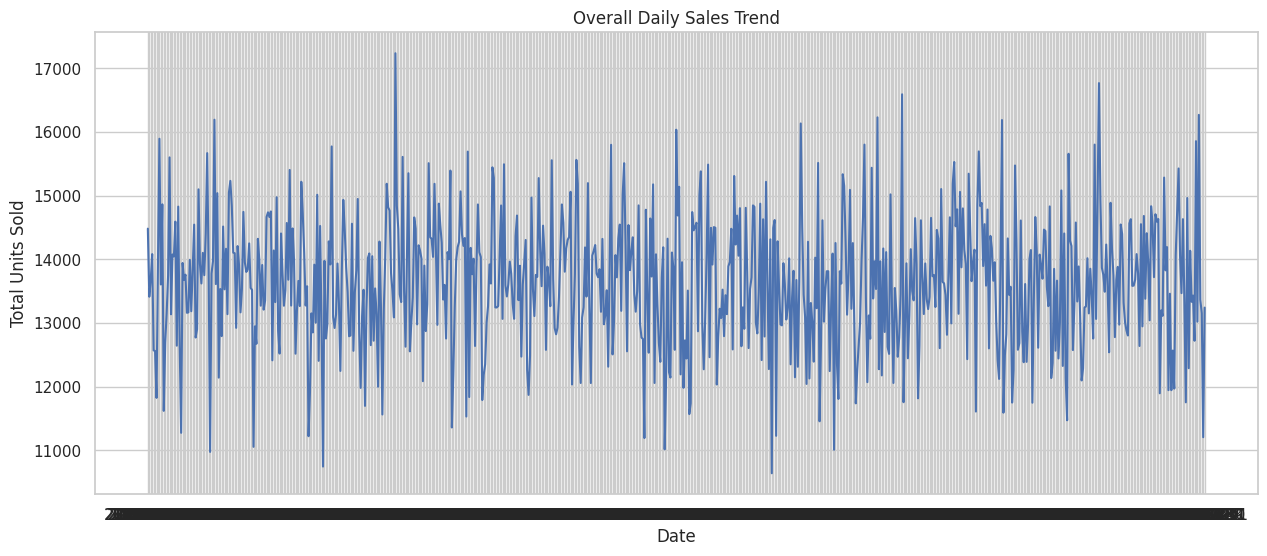

In [69]:
# Aggregate total sales by date
daily_sales = df.groupby('Date')['Units Sold'].sum().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(data=daily_sales, x='Date', y='Units Sold')
plt.title('Overall Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')
plt.show()


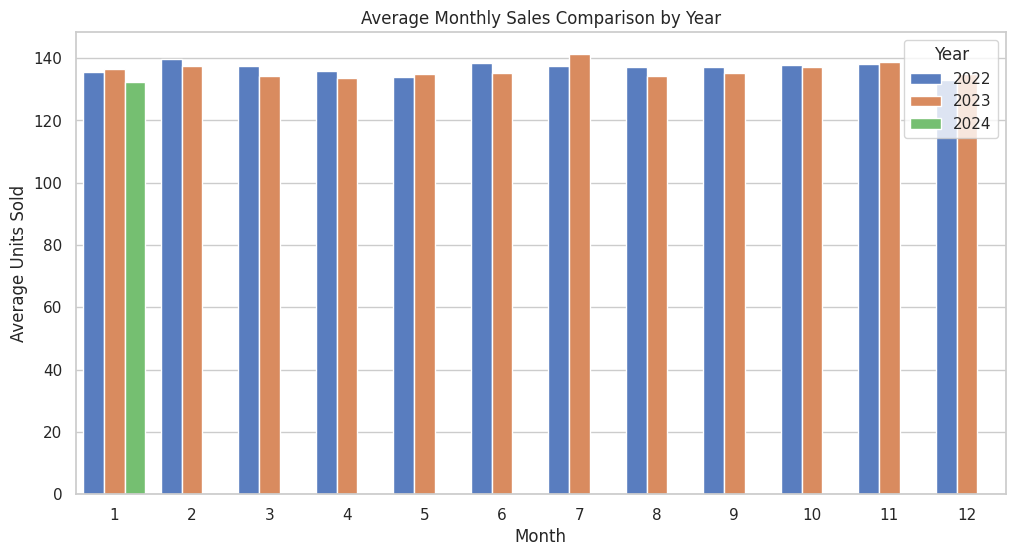

In [72]:
# Ensure 'Date' is datetime and 'Year', 'Month' columns exist for grouping
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    if 'Year' not in df.columns:
        df['Year'] = df['Date'].dt.year
    if 'Month' not in df.columns:
        df['Month'] = df['Date'].dt.month
else:
    print("❌ Error: 'Date' column is missing, cannot extract Year/Month.")

# Aggregate average sales by year and month
monthly_sales = df.groupby(['Year', 'Month'])['Units Sold'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=monthly_sales,
    x='Month',
    y='Units Sold',
    hue='Year',
    palette='muted'
)

plt.title('Average Monthly Sales Comparison by Year')
plt.xlabel('Month')
plt.ylabel('Average Units Sold')
plt.legend(title='Year')
plt.show()

# 3. Feature Engineering

In [73]:
# Sort by Store and Date to avoid data leakage
df.sort_values(by=['Store ID', 'Date'], inplace=True)

print("Data sorted by Store ID and Date.")


Data sorted by Store ID and Date.


In [74]:
grouped = df.groupby('Store ID')['Units Sold']

# 7-day rolling features (shifted by 1)
df['Rolling_Mean_7'] = grouped.transform(
    lambda x: x.shift(1).rolling(window=7).mean()
)

df['Rolling_Std_7'] = grouped.transform(
    lambda x: x.shift(1).rolling(window=7).std()
)

display(df[['Store ID', 'Date', 'Units Sold', 'Rolling_Mean_7', 'Rolling_Std_7']].head(10))


,Store ID,Date,Units Sold,Rolling_Mean_7,Rolling_Std_7
0,S001,2022-01-01,127,NaN,NaN
1,S001,2022-01-01,150,NaN,NaN
2,S001,2022-01-01,65,NaN,NaN
3,S001,2022-01-01,61,NaN,NaN
4,S001,2022-01-01,14,NaN,NaN
5,S001,2022-01-01,128,NaN,NaN
6,S001,2022-01-01,97,NaN,NaN
7,S001,2022-01-01,312,91.714286,47.755329
8,S001,2022-01-01,175,118.142857,96.673727
9,S001,2022-01-01,28,121.714286,98.491479


In [75]:
df.fillna(
    {
        'Rolling_Mean_7': 0,
        'Rolling_Std_7': 0
    },
    inplace=True
)

print("NaN values from rolling features handled.")


NaN values from rolling features handled.


In [76]:
if 'Temperature' in df.columns:
    df['Temperature'] = df['Temperature'].fillna(df['Temperature'].mean())
    print("Temperature column cleaned.")
else:
    print("⚠️ Warning: 'Temperature' column not found.")


⚠️ Warning: 'Temperature' column not found.


#  4. Forecasting Model

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

sns.set_theme(style="whitegrid")


In [93]:
# Work on a copy to keep original df safe
model_df = df.copy()

print("Modeling dataframe created.")


Modeling dataframe created.


In [94]:
categorical_cols = [
    'Store ID', 'Product ID', 'Category', 'Region',
    'Weather Condition', 'Holiday/Promotion',
    'Seasonality', 'Temp_Category'
]

le = LabelEncoder()

for col in categorical_cols:
    if col in model_df.columns:
        model_df[col] = model_df[col].astype(str)
        model_df[col + '_Code'] = le.fit_transform(model_df[col])

print("Categorical encoding completed.")


Categorical encoding completed.


In [95]:
potential_features = [
    'Demand Forecast', 'Price', 'Discount', 'Competitor Pricing',
    'Inventory Level', 'Units Ordered', 'Month', 'Rolling_Mean_7'
]

# Add encoded categorical features
potential_features += [
    col + '_Code' for col in categorical_cols if col in model_df.columns
]

# Keep only existing columns
features = [col for col in potential_features if col in model_df.columns]
target = 'Units Sold'

print("Training Features:")
print(features)


Training Features:
['Demand Forecast', 'Price', 'Discount', 'Competitor Pricing', 'Inventory Level', 'Units Ordered', 'Month', 'Rolling_Mean_7', 'Store ID_Code', 'Product ID_Code', 'Category_Code', 'Region_Code', 'Weather Condition_Code', 'Holiday/Promotion_Code', 'Seasonality_Code']


In [96]:
X = model_df[features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Training Data Size: {len(X_train)}")
print(f"Test Data Size: {len(X_test)}")


Training Data Size: 58480
Test Data Size: 14620


In [85]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=15, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

print("Models initialized.")


Models initialized.


In [86]:
results = []

print("\n--- Model Evaluation Results ---")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'RMSE': rmse,
        'R2 Score': r2
    })

    print(f"{name:<20} | RMSE: {rmse:.2f} | R2: {r2:.4f}")



--- Model Evaluation Results ---
Linear Regression    | RMSE: 8.66 | R2: 0.9936
Decision Tree        | RMSE: 10.10 | R2: 0.9913
Random Forest        | RMSE: 8.54 | R2: 0.9938
Gradient Boosting    | RMSE: 8.43 | R2: 0.9940


,Model,RMSE,R2 Score
3,Gradient Boosting,8.427139,0.993960
2,Random Forest,8.543182,0.993793
0,Linear Regression,8.658278,0.993625
1,Decision Tree,10.096111,0.991331


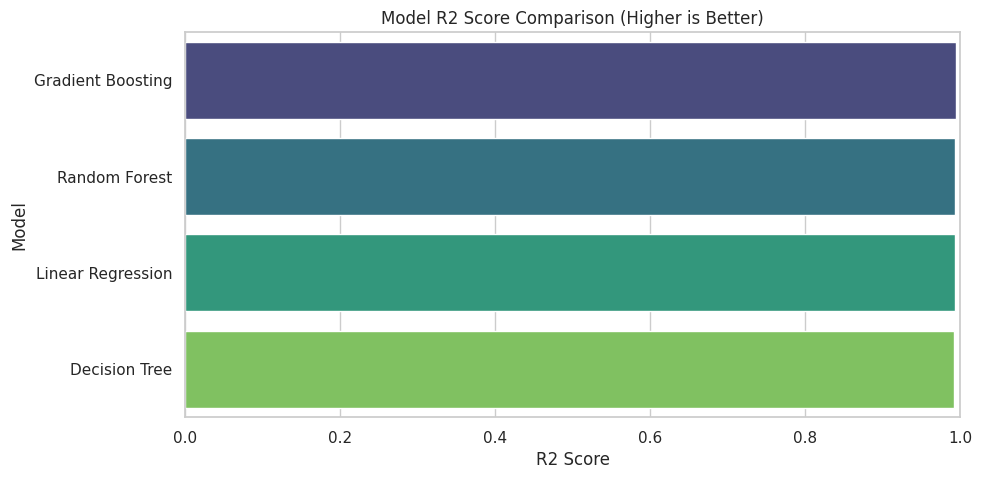

In [87]:
results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
display(results_df)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=results_df,
    x='R2 Score',
    y='Model',
    hue='Model',
    palette='viridis',
    legend=False
)

plt.title('Model R2 Score Comparison (Higher is Better)')
plt.xlim(0, 1)
plt.show()


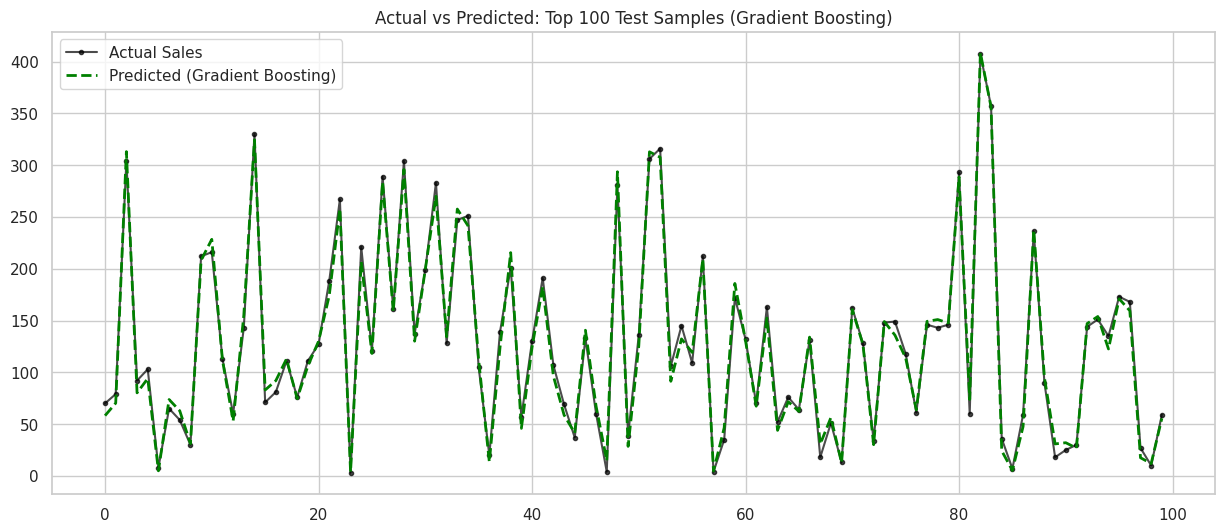

,Model,RMSE,R2 Score
3,Gradient Boosting,8.427139,0.993960
2,Random Forest,8.543182,0.993793
0,Linear Regression,8.658278,0.993625
1,Decision Tree,10.096111,0.991331


In [88]:

#  Best Model Visualization ---
# Pick the best model from the results
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(15, 6))
# Sort by index to make the line graph look continuous if data was time-series
# Since we shuffled, we just plot the first 100 random samples to avoid a messy scribbled line.
plt.plot(y_test.values[:100], label='Actual Sales', marker='.', color='black', alpha=0.7)
plt.plot(y_pred_best[:100], label=f'Predicted ({best_model_name})', linestyle='--', linewidth=2, color='green')
plt.title(f'Actual vs Predicted: Top 100 Test Samples ({best_model_name})')
plt.legend()
plt.show()

# Display the final metrics table
display(results_df)

#  5. Business Insights & Visualization




In [91]:
# 1. Feature Importance Analysis
# We use the Random Forest model to find what drives sales
best_rf_model = models["Random Forest"]

importances = best_rf_model.feature_importances_
fi_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

fi_df

,Feature,Importance
0,Demand Forecast,0.996738
4,Inventory Level,0.000628
7,Rolling_Mean_7,0.000423
5,Units Ordered,0.000397
1,Price,0.000301
3,Competitor Pricing,0.000298
9,Product ID_Code,0.000261
6,Month,0.000213
10,Category_Code,0.000128
8,Store ID_Code,0.000127


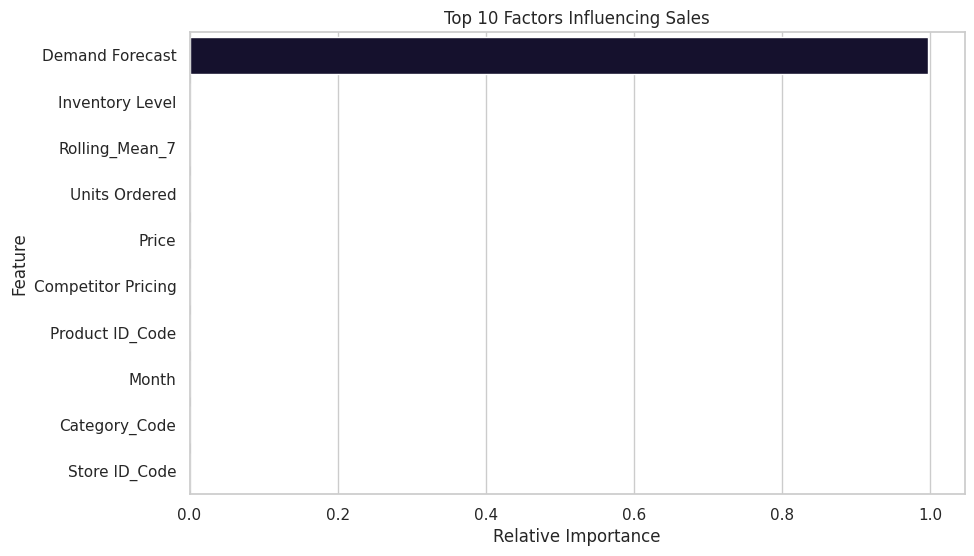

In [90]:
# 2. Visualizing Key Factors
plt.figure(figsize=(10, 6))

sns.barplot(data=fi_df, x='Importance', y='Feature', hue='Feature', palette='magma', legend=False)
plt.title('Top 10 Factors Influencing Sales')
plt.xlabel('Relative Importance')
plt.show()